In [1]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Read the data
X_train_full = pd.read_csv('/kaggle/input/german-credit/german_credit_data.csv', index_col=0)

X_train_full.head(10).T

,0,1,2,3,4,5,6,7,8,9
Age,67,22,49,45,53,35,53,35,61,28
Sex,male,female,male,male,male,male,male,male,male,male
Job,2,2,1,2,2,1,2,3,1,3
Housing,own,own,own,free,free,free,own,rent,own,own
Saving accounts,NaN,little,little,little,little,NaN,quite rich,little,rich,little
Checking account,little,moderate,NaN,little,little,NaN,NaN,moderate,NaN,moderate
Credit amount,1169,5951,2096,7882,4870,9055,2835,6948,3059,5234
Duration,6,48,12,42,24,36,24,36,12,30
Purpose,radio/TV,radio/TV,education,furniture/equipment,car,education,furniture/equipment,car,radio/TV,car


In [2]:
# Агрегируем данные по датафрейму в одну таблицу
features_data = pd.DataFrame(index=X_train_full.columns)

# Тип данных
features_data['Type'] = X_train_full.dtypes
# Пропущенные данные
features_data['NaN'] = X_train_full.isna().sum()
features_data['NaN percent'] = (X_train_full.isna().sum() / X_train_full.shape[0]) * 100
# Уникальные значения
features_data['Unique'] = pd.DataFrame([len(X_train_full[item].unique()) for item in X_train_full.columns], index=features_data.index)
features_data['Unique vals'] = pd.DataFrame([str(list(X_train_full[item].unique())) for item in X_train_full.columns], index=features_data.index)

# Статистика
quantiles = [0.01, 0.50, 0.99]
features_train_desc = X_train_full.describe(quantiles).T
features_data = features_data.join(features_train_desc, how='left')

features_data

,Type,NaN,NaN percent,Unique,Unique vals,count,mean,std,min,1%,50%,99%,max
Age,int64,0,0.0,53,"[67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 3...",1000.0,35.546,11.375469,19.0,20.00,33.0,67.01,75.0
Sex,object,0,0.0,2,"['male', 'female']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,int64,0,0.0,4,"[2, 1, 3, 0]",1000.0,1.904,0.653614,0.0,0.00,2.0,3.00,3.0
Housing,object,0,0.0,3,"['own', 'free', 'rent']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,object,183,18.3,5,"[nan, 'little', 'quite rich', 'rich', 'moderate']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,object,394,39.4,4,"['little', 'moderate', nan, 'rich']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,int64,0,0.0,921,"[1169, 5951, 2096, 7882, 4870, 9055, 2835, 694...",1000.0,3271.258,2822.736876,250.0,425.83,2319.5,14180.39,18424.0
Duration,int64,0,0.0,33,"[6, 48, 12, 42, 24, 36, 30, 15, 9, 10, 7, 60, ...",1000.0,20.903,12.058814,4.0,6.00,18.0,60.00,72.0
Purpose,object,0,0.0,8,"['radio/TV', 'education', 'furniture/equipment...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
categorical_col = list(features_data[features_data['Type'] == 'object'].index.values)
numerical_col = list(features_data[features_data['Type'] != 'object'].index.values)

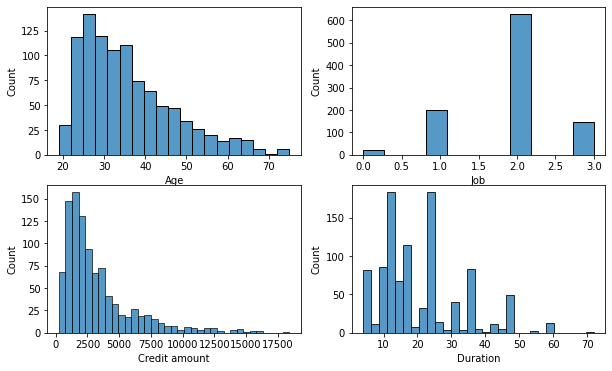

In [4]:
numerical_col_len = len(numerical_col)

fig, axes = plt.subplots(nrows=numerical_col_len//2, ncols=2,  figsize=(10,6))
for i in range(numerical_col_len):
    sns.histplot(x=numerical_col[i], data=X_train_full, ax=axes[i//2][i%2])

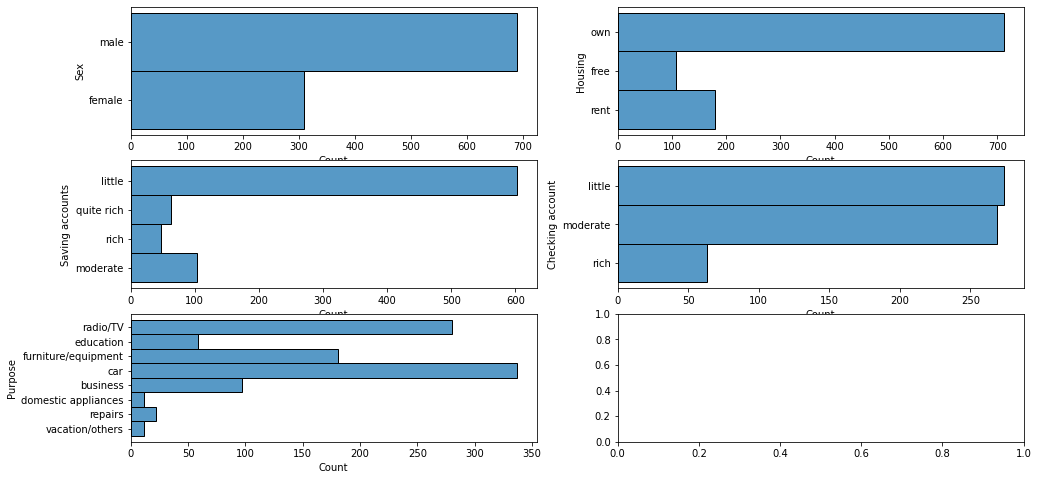

In [5]:
categorical_col_len = len(categorical_col)

fig, axes = plt.subplots(nrows=3, ncols=2,  figsize=(16,8))
for i in range(categorical_col_len):
    sns.histplot(y=categorical_col[i], data=X_train_full, ax=axes[i//2][i%2])

Преобразуем данные.
1) 'Checking account' и 'Saving accounts' имеют много пропусков. ПОка заменем пропуски на спец. лейбл.

2) 'Checking account' и 'Saving accounts' являются качественной оценкой по сути количественного признака, еоторый можно проградуировать и числами. Сделаем это вручную.
Для 'No Data' закодируем -1. 

3) 'Sex', 'Housing', 'Purpose' - имеют немгного уникальных значений, распределение неравномерное, попробуем взять ohe. 
Далее будут работать алгориты снижения размерности. Рискну предположить, числосвйоств которое можно будет сократить, будет соотноситься с числом новых свойств введеныйх OHE.

In [6]:
from sklearn.preprocessing import LabelEncoder 

def data_processing(X_train_full):
    X_train_full['Checking account'].fillna(value='No Data', inplace=True)
    X_train_full['Saving accounts'].fillna(value='No Data', inplace=True)

    grad_map_1={'No Data': -1, 'little': 1, 'quite rich':3, 'rich':4, 'moderate': 2}
    X_train_full['Saving accounts'] = X_train_full['Saving accounts'].replace(grad_map_1)

    grad_map_2={'No Data': -1, 'little': 1, 'rich':3, 'moderate': 2}
    X_train_full['Checking account'] = X_train_full['Checking account'].replace(grad_map_2)
   
    grad_map_3={'male': 0, 'female': 1}
    X_train_full['Sex'] = X_train_full['Sex'].replace(grad_map_3)
    
    X_train_full = pd.get_dummies(X_train_full, columns=['Housing', 'Purpose'], prefix_sep='=')
    #cat_cols = ['Sex', 'Housing', 'Purpose']
    #for col in cat_cols:
    #    X_train_full[col] = LabelEncoder().fit_transform(X_train_full[col])
    
    return X_train_full

new_categorical_cols = [
 'Housing=free',
 'Housing=own',
 'Housing=rent',
 'Purpose=business',
 'Purpose=car',
 'Purpose=domestic appliances',
 'Purpose=education',
 'Purpose=furniture/equipment',
 'Purpose=radio/TV',
 'Purpose=repairs',
 'Purpose=vacation/others',
 'Sex']

X_train_full_ = data_processing(X_train_full.copy())
X_train_full_.head().T

,0,1,2,3,4
Age,67,22,49,45,53
Sex,0,1,0,0,0
Job,2,2,1,2,2
Saving accounts,-1,1,1,1,1
Checking account,1,2,-1,1,1
Credit amount,1169,5951,2096,7882,4870
Duration,6,48,12,42,24
Housing=free,0,0,0,1,1
Housing=own,1,1,1,0,0
Housing=rent,0,0,0,0,0


Параметры Credit amount и, допустим, Job резко отличаются по масштабу. Надо нормализовывать. 

In [7]:
from sklearn.preprocessing import StandardScaler

std_transformer = StandardScaler()

X_train_full_std = std_transformer.fit_transform(X_train_full_[new_categorical_cols+numerical_col])
print(X_train_full_std.shape)
X_train_full_std

(1000, 16)


array([[-0.3479601 ,  0.63444822, -0.4669334 , ...,  0.14694918,
        -0.74513141, -1.23647786],
       [-0.3479601 ,  0.63444822, -0.4669334 , ...,  0.14694918,
         0.94981679,  2.24819436],
       [-0.3479601 ,  0.63444822, -0.4669334 , ..., -1.38377145,
        -0.41656241, -0.73866754],
       ...,
       [-0.3479601 ,  0.63444822, -0.4669334 , ...,  0.14694918,
        -0.87450324, -0.73866754],
       [ 2.8738927 , -1.57617276, -0.4669334 , ...,  0.14694918,
        -0.50552769,  1.9992892 ],
       [-0.3479601 ,  0.63444822, -0.4669334 , ...,  0.14694918,
         0.46245715,  1.9992892 ]])

K-means

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

k_max=9 
inertia = []
silhouette = []

for k in range(1,k_max):
    kmeans_k = KMeans(n_clusters=k, random_state=12).fit(X_train_full_std) #12
    inertia.append(np.sqrt(kmeans_k.inertia_))
    
    if (k > 1):
        silhouette_avg = silhouette_score(X_train_full_std, kmeans_k.labels_)
        silhouette.append(silhouette_avg)
    
d_list = [] 
k_list = [i for i in range(2, k_max-1)]

for k in k_list: 
    i = k - 1
    d = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    d_list.append(d)

print(silhouette)
print(d_list)

[0.17162590398341432, 0.21755086872144616, 0.1536013089963443, 0.17078268367600427, 0.21441707792176848, 0.24989394783588642, 0.2701539434879734]
[1.0225734576923946, 0.6863927878909946, 1.0051710726329606, 0.9098077067725051, 1.1021901202558277, 1.1316625997552334]


Text(0.5, 1.0, 'The average silhouette_score')

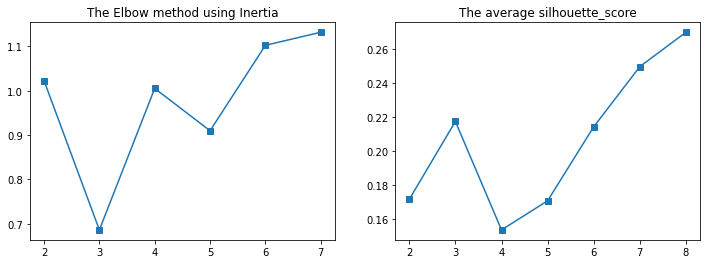

In [9]:
#fig, axs = plt.subplots(2, figsize=(10,6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(k_list, d_list, marker='s') 
axes[0].set_title("The Elbow method using Inertia") 

axes[1].plot(range(2,k_max), silhouette, marker='s') 
axes[1].set_title("The average silhouette_score") 

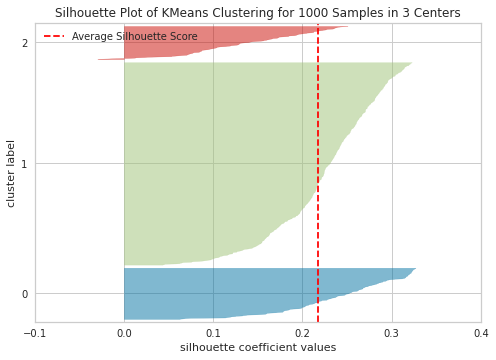

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(3, random_state=12)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_train_full_std)        # Fit the data to the visualizer
visualizer.show()  

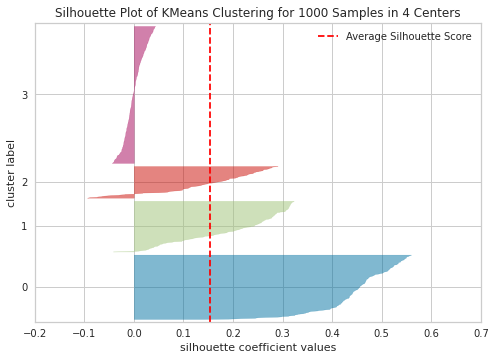

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
model = KMeans(4, random_state=12)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_train_full_std)        # Fit the data to the visualizer
visualizer.show()  

Сразу оговорюсь, что random_state сильно влияет на инерцию и силуэт. Поэтому в зависимости от random_state лидерами становились и 2, и 3, и 4 кластера.
По анотации датасета, делить надо на две категории: "хорошие" кредиты и "плохие". Но здесь мы скорее изучаем работу алгоритмов поэтому я остановился на варианте когда "локти" и "силуэты"  показли оптимальным разделение на три кластера. Будем использовать этот параметр для KMeans и иерахической классификации. 

In [12]:
n_clusters_kmeans = 3

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=12).fit(X_train_full_std)
kmeans_labels = kmeans.labels_
#kmeans_labels

In [13]:
from sklearn.cluster import AgglomerativeClustering

n_clusters_agc = 3
linkage = ['ward', 'average', 'complete', 'single']

agc = AgglomerativeClustering(n_clusters=n_clusters_agc, linkage=linkage[0])
agc.fit(X_train_full_std)

agc_labels = agc.labels_

In [14]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=4.3, min_samples=4).fit(X_train_full_std)
dbscan_labels = dbscan.labels_
print( np.unique(dbscan_labels))
pd.Series(dbscan_labels).value_counts()

[-1  0  1  2  3  4]


 0    895
 1     59
 3     22
 2     12
 4      9
-1      3
dtype: int64

Чистый DBSCAN записывает подавляющее большинство записей в одну категорию. Видимо между кластерами нет чёткой границы или шум создаёт «мост» между скоплениями.
Попробуем "разтащить" кластеры. Используем UMAP, чтоб уж наверняка.

In [15]:
import umap

dbscan = DBSCAN(eps=1.2, min_samples=5).fit(umap.UMAP(n_components=7, random_state=3).fit_transform(X_train_full_std))
dbscan_labels_umap = dbscan.labels_
print( np.unique(dbscan_labels_umap))
pd.Series(dbscan_labels_umap).value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


7     176
0     159
5     105
8      97
1      68
3      67
6      63
14     48
2      44
9      43
10     38
13     22
11     17
4      15
16     14
12     12
15     12
dtype: int64

Уже интересней. Тюнинг eps и min_samples дает крайне схожие результаты. Более чувствительно здесь n_components в UMAP.

Теперь посмотрим как именно наши алгоритмы распределили данные по кластерам. Для этого Переведем наши данные в двумерное пространство с помощью алгоритмов PCA, tNSE, UMAP. 

In [16]:
!pip install MulticoreTSNE

  Preparing metadata (setup.py) ... - done
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=64713 sha256=b2521bbde6b658cf4165935f9fea2b551b6e5ecf8b5b8a7e8451a3aba6d12b9c
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE


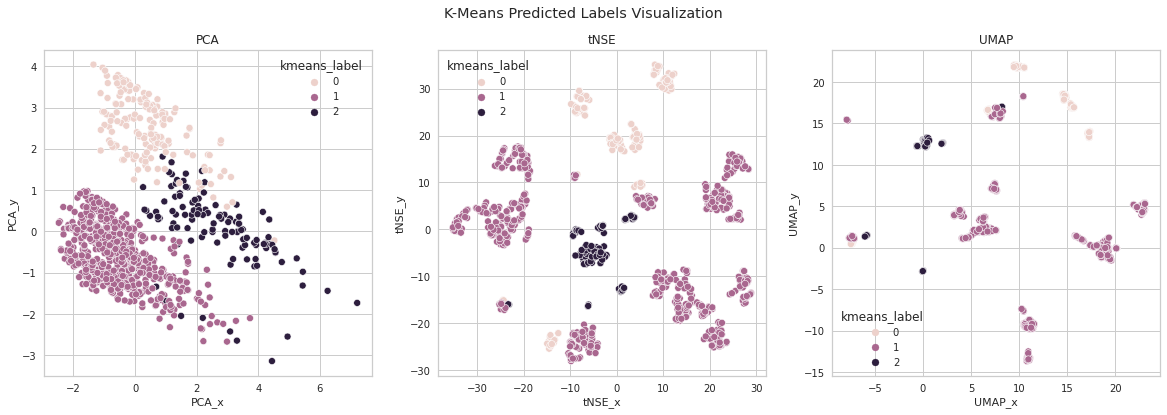

In [17]:
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import umap

decomposition_model_labels = [
    'PCA',
    'tNSE',
    'UMAP',
]

decomposition_models = [
    PCA(n_components=2),
    TSNE(n_components=2, random_state=3, n_jobs=-1),
    umap.UMAP(n_components=2, random_state=3)
]

data_2d = pd.DataFrame(kmeans_labels, columns=['kmeans_label'])
#data_2d['kmeans_label'] = kmeans_labels


for i, model in enumerate(decomposition_models):
    #print(i, decomposition_model_labels[i])
    data = pd.DataFrame(model.fit_transform(X_train_full_std))
    data_2d[decomposition_model_labels[i]+'_x'] = data[0]
    data_2d[decomposition_model_labels[i]+'_y'] = data[1]


fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20,6))
fig.suptitle("K-Means Predicted Labels Visualization")
for i, label in enumerate(decomposition_model_labels):
    sns.scatterplot(x=data_2d[label+'_x'], y=data_2d[label+'_y'], hue=data_2d['kmeans_label'], ax=axes[i])
    axes[i].set_title(label) 


В целом K-Means справился неплохо. Даже на PCA кластеры явно просматриваются.

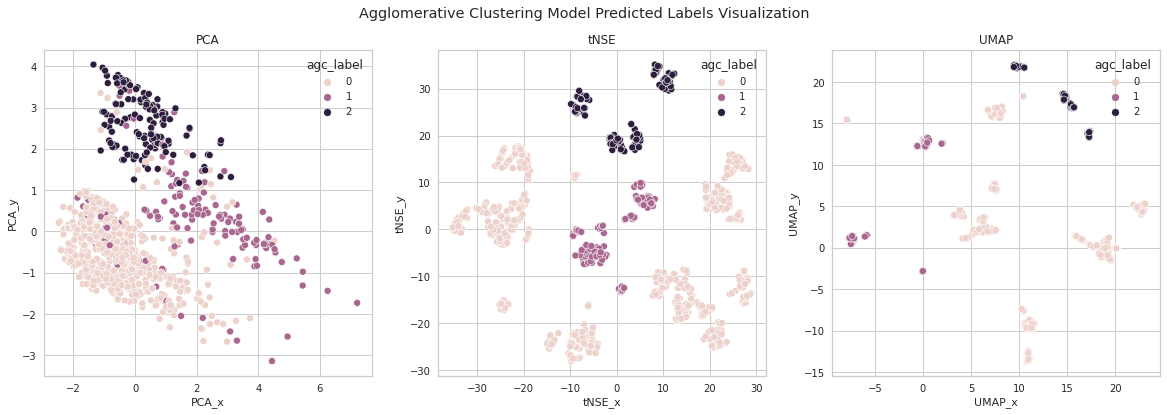

In [18]:
data_2d['agc_label'] = agc_labels


fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20,6))
fig.suptitle("Agglomerative Clustering Model Predicted Labels Visualization")
for i, label in enumerate(decomposition_model_labels):
    sns.scatterplot(x=data_2d[label+'_x'], y=data_2d[label+'_y'], hue=data_2d['agc_label'], ax=axes[i])
    axes[i].set_title(label) 


Результаты работы Agglomerative Clustering Model тоже явно просматриваются.

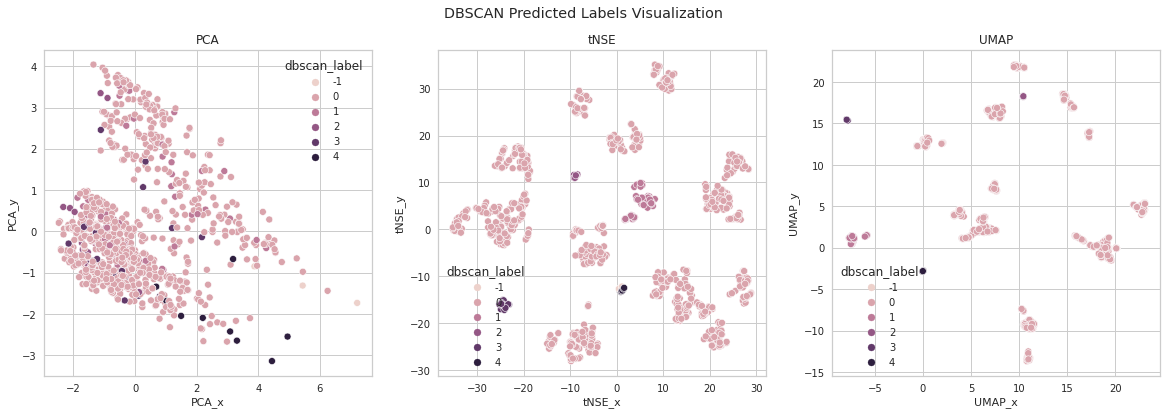

In [19]:
data_2d['dbscan_label'] = dbscan_labels
fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20,6))
fig.suptitle("DBSCAN Predicted Labels Visualization")
for i, label in enumerate(decomposition_model_labels):
    sns.scatterplot(x=data_2d[label+'_x'], y=data_2d[label+'_y'], hue=data_2d['dbscan_label'], ax=axes[i])
    axes[i].set_title(label) 

Здесь почти все данные в одном кластеры. Деление оставшихся видно только на tNSE и UMAP

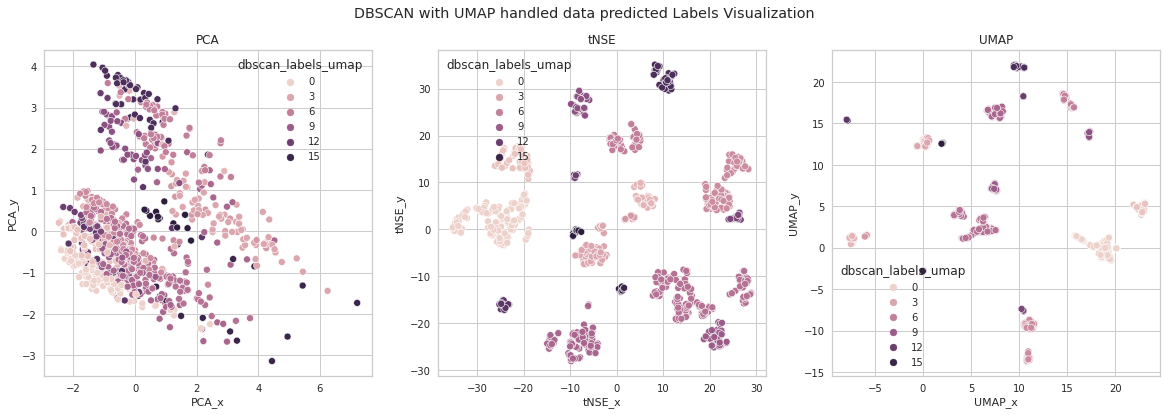

In [20]:
data_2d['dbscan_labels_umap'] = dbscan_labels_umap
fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(20,6))
fig.suptitle("DBSCAN with UMAP handled data predicted Labels Visualization")
for i, label in enumerate(decomposition_model_labels):
    sns.scatterplot(x=data_2d[label+'_x'], y=data_2d[label+'_y'], hue=data_2d['dbscan_labels_umap'], ax=axes[i])
    axes[i].set_title(label) 

#data_2d.head()

Здесь лучше. Кластеры просматриваются на PCA.

**Теперь попробуем интерпретировать как алгоритмы поделили данные.**

In [21]:
X_train_full['kmeans_label'] = kmeans_labels
X_train_full.groupby('kmeans_label').mean()

,Age,Job,Credit amount,Duration
kmeans_label,,,,
0,30.368715,1.849162,3122.553073,19.240223
1,35.575887,1.870922,2996.946099,20.241135
2,43.353448,2.189655,5167.879310,27.491379


У записей с меткой 2 параметры Job, Credit amount выше чем, у других меток. Из общих соображений обладатели этих записей могут 
рассматриваться как более платежеспособные.  Разница между метками 0 и 1 
пока туманна. 

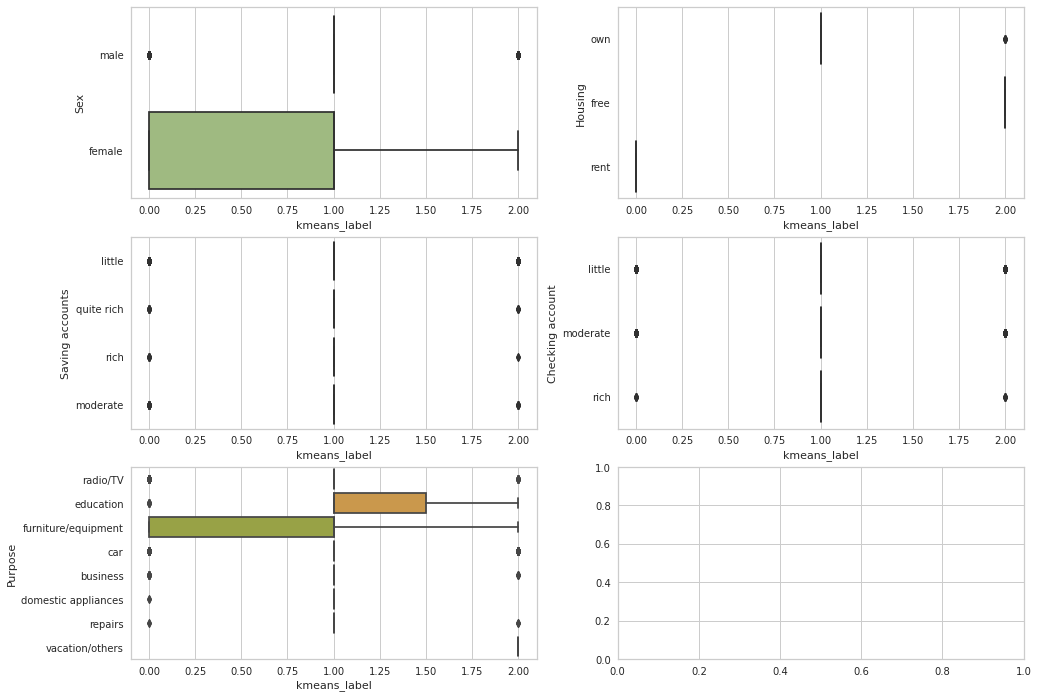

In [22]:

fig, axes = plt.subplots(nrows=3, ncols=2,  figsize=(16,12))
#for i in range(len(new_categorical_cols)):
for i in range(len(categorical_col)):
    #print(new_categorical_cols[i])
    sns.boxplot(y=categorical_col[i], x='kmeans_label', data=X_train_full, ax=axes[i//2][i%2])
    #sns.barplot(y=categorical_col[i], x='kmeans_label', data=X_train_full[X_train_full['kmeans_label'] != 1], ax=axes[i//2][i%2])

Похоже K-means просто разделил всех по параметру housing

Посмотри на результаты DBSCAN (улучшенные)

In [23]:
X_train_full['dbscan_labels_umap'] = dbscan_labels_umap
X_trimmed = X_train_full.query('dbscan_labels_umap == 0 | dbscan_labels_umap == 5 | dbscan_labels_umap == 7 | dbscan_labels_umap == 8')
X_trimmed.groupby('dbscan_labels_umap').mean()

,Age,Job,Credit amount,Duration,kmeans_label
dbscan_labels_umap,,,,,
0,35.761006,1.874214,2553.754717,20.471698,1.000000
5,33.914286,2.076190,3259.009524,20.380952,1.000000
7,36.295455,2.142045,3540.380682,21.250000,1.000000
8,35.484536,1.907216,4158.041237,26.938144,0.886598


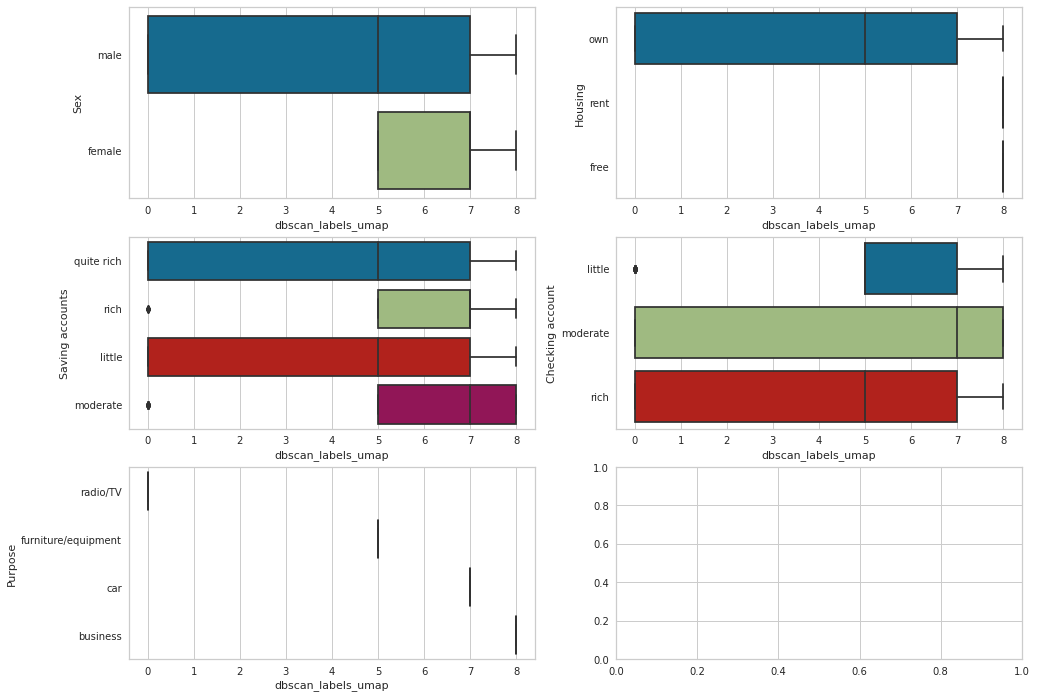

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2,  figsize=(16,12))
for i in range(len(categorical_col)):
    sns.boxplot(y=categorical_col[i], x='dbscan_labels_umap', data=X_trimmed, ax=axes[i//2][i%2])


Похоже здесь деление произошло в основном по параметру Purpose. Это кстати объясняет почему эти лейблы самые рапостранённые.

Здесь результаты классификации скорее неудачные. Но резюме положительное: надо очень аккуратно подбирать параметры и интерпретировать результаты, иначе можно получить обсалютно бессмысленные результаты. 